## LTV modeling of the Dram Shop

In [ ]:
# You may need to uncomment and run this line
#!pip install Lifetimes

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes.utils import summary_data_from_transaction_data as summary
from lifetimes import BetaGeoFitter, GammaGammaFitter

from google.cloud import bigquery
from google.oauth2 import service_account

# Create a BigQuery client 
client = bigquery.Client()
project_id = 'umt-msba'


In [6]:
# Define your query
customer_query = """
    SELECT
      COALESCE(o.customer_id, o.square_unique_id) AS customer_id,
      o.order_id AS id,
      o.created_at,
      ROUND(o.total_money / 100, 2) AS subtotal_price             
    FROM
      `umt-msba.dram_shop.orders_*` o
    WHERE
      COALESCE(o.customer_id, o.square_unique_id) != ""
      AND o.created_at BETWEEN "2022-10-01"
      AND "2024-10-01"
    ORDER BY
      o.created_at;
"""

# Run the query and convert the results into a pandas DataFrame
df = client.query(customer_query).to_dataframe()

print(f"Dataframe has {df.shape[0]} rows and {df.shape[1]} columns")
df.head()


Dataframe has 72952 rows and 4 columns


,customer_id,id,created_at,subtotal_price
0,B6AYDE1VTN5T91K4B4JRSN4B24,kwh2B9uJtS3cuL2v0hoD4RieV,2022-10-01 00:00:12+00:00,19.0
1,GZ8Z6B3GS52BZ1JKVTXSAF125W,JaFC7oQQJmnUyyQlKz70KCveV,2022-10-01 00:05:30+00:00,19.0
2,TXRRWY97PD53D678049TR86F9G,pyL5oDvhrCgfnYBlBkRuxQleV,2022-10-01 00:05:58+00:00,8.0
3,RDENZMP38H0KH45QMPANBPCDHM,duWSaFKjiGvWLV8fRTB53YweV,2022-10-01 00:06:46+00:00,7.0
4,DJZXJKT4VH3QV1Y6RBRWMNNWX0,QuLJNlBrUFlavyrxIArPxQ8eV,2022-10-01 00:08:19+00:00,14.0


In [7]:
# Convert created_at to datetime and subtotal_price to float
df['created_at'] = pd.to_datetime(df['created_at'])
df['subtotal_price'] = df['subtotal_price'].astype(float)

# Verify the conversion
df.dtypes


customer_id                    object
id                             object
created_at        datetime64[us, UTC]
subtotal_price                float64
dtype: object

In [9]:
# Summarize data for the CLV model
summary_df = summary(df, 'customer_id', 'created_at', 
                     monetary_value_col='subtotal_price', 
                     observation_period_end='2024-09-01',
                     freq="W") # "D" is the default (days), which is fine  


/opt/anaconda3/lib/python3.11/site-packages/lifetimes/utils.py:203: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transactions = transactions.set_index(datetime_col).to_period(freq).to_timestamp()


In [10]:
# Fit the BetaGeoFitter model to predict the number of future transactions
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary_df['frequency'], summary_df['recency'], summary_df['T'])

# Print model summary
print(bgf.summary)


           coef  se(coef)  lower 95% bound  upper 95% bound
r      0.222674  0.003424         0.215963         0.229385
alpha  5.410049  0.130347         5.154569         5.665528
a      0.222024  0.007887         0.206565         0.237483
b      0.706510  0.025819         0.655904         0.757116


In [17]:
print(f"alpha/r is the repurchase rate: {bgf.summary.iloc[1,0]/bgf.summary.iloc[2,0]:.2f} weeks.")
print(f"a/(a+b) is drop out probability after a purchase: {100* bgf.summary.iloc[2,0]/(bgf.summary.iloc[2,0]+bgf.summary.iloc[3,0]):.2f}%.")

alpha/r is the repurchase rate: 24.37 weeks.
a/(a+b) is drop out probability after a purchase: 23.91%.


Let's interpret these (pretty opaque) model terms. Here's an intuitive interpretation of these BG/NBD parameters:

* `r = 0.223 and alpha = 5.4`:
  * These shape the purchasing process. 
  * With a low r and high alpha, this tells us customers tend to have relatively low but consistent purchase rates. 
  * The average customer makes a purchase every (alpha/r) ≈ 24 weeks. 
  * The low r suggests there isn't much variation between customers' purchase rates - most follow this pattern fairly closely.

* `a = 0.22 and b = 0.71`:
  * These describe the dropout process. 
  * The ratio a/(a+b) ≈ 24% represents the probability of dropping out after any purchase. 
  * The low a and b values suggest there's high variation in dropout patterns between customers. 
  * Some customers stick around for a long time, while others drop out quickly.

In business terms, this looks like a business where:
  * Customers purchase fairly predictably but not very frequently
  * There's a roughly 24% chance of losing a customer after each purchase
  * While the average behavior is clear, individual customers vary quite a bit in how long they stay active
  * Once customers establish a purchase pattern, they tend to stick to it (low variation in purchase rates)

We suspect that the Dram shop is a mixture of customer types, with some people who are just traveling through town, others who are occasional visitors, and regulars. 

How could we combine our techniques to improve our models?  

In [18]:
# Fit the GammaGammaFitter model to predict the monetary value of future transactions
returning_customers = summary_df[summary_df['frequency'] > 0]
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(returning_customers['frequency'], returning_customers['monetary_value'])

# Print model summary
print(ggf.summary)


       coef  se(coef)  lower 95% bound  upper 95% bound
p  4.132794  0.049844         4.035100         4.230488
q  1.134739  0.015325         1.104702         1.164777
v  3.818953  0.049853         3.721242         3.916664


Let's interpret these Gamma-Gamma parameters:

`p = 4.13, q = 1.13, and v = 3.82`:

* These shape the distribution of customer spending patterns
    * p represents the shape of the gamma distribution of purchase amounts
    * The relatively high p (4.13) suggests moderate variation in individual customers' purchase amounts
    * v represents the degrees of freedom in customer heterogeneity
    * The moderate v (3.82) indicates substantial variation between customers' average spending
    * q is a second shape parameter affecting the relationship between frequency and spending

In business terms, this model suggests:
  * There's significant variation in how much different customers spend
  * Individual customers tend to be somewhat consistent in their purchase amounts
  * The spending patterns don't strongly correlate with purchase frequency
  * The average transaction value is stable but allows for some big spenders

The model is suggesting that while customers vary quite a bit in their average spend, they tend to be relatively consistent with their own spending patterns once established.

In [20]:
ggf.conditional_expected_average_profit()

0       23.352534
1       38.046031
2       20.082113
3       29.280362
4       10.477365
          ...    
8790    35.006504
8791    17.253227
8792    30.330115
8793     9.626278
8794    16.287926
Length: 8795, dtype: float64

In [21]:
# Overall average
print(f"Overall average expected spend per transaction: ${ggf.conditional_expected_average_profit(returning_customers['frequency'], returning_customers['monetary_value']).mean():.2f}")

# Let's look at the distribution
spending_predictions = ggf.conditional_expected_average_profit(returning_customers['frequency'], returning_customers['monetary_value'])
print(f"25th percentile: ${spending_predictions.quantile(0.25):.2f}")
print(f"Median expected spend: ${spending_predictions.quantile(0.50):.2f}")
print(f"75th percentile: ${spending_predictions.quantile(0.75):.2f}")

Overall average expected spend per transaction: $27.50
25th percentile: $17.26
Median expected spend: $23.55
75th percentile: $32.63


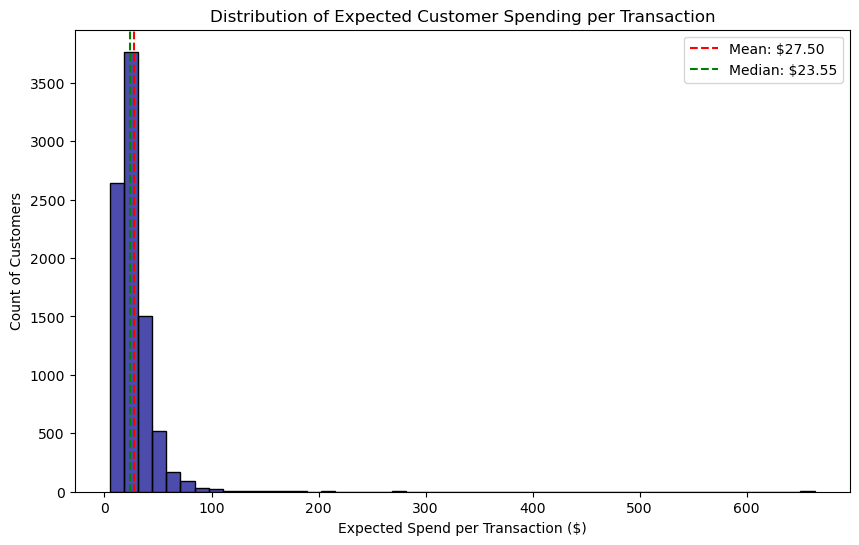

Mean expected spend: $27.50
Median expected spend: $23.55
Standard deviation: $20.11

Percentiles:
count    8795.000000
mean       27.495500
std        20.106380
min         5.151017
10%        12.702411
25%        17.256353
50%        23.551127
75%        32.633515
90%        44.786269
max       663.439173
dtype: float64


In [26]:

# Calculate expected spending for each customer
spending_predictions = ggf.conditional_expected_average_profit(
    returning_customers['frequency'], 
    returning_customers['monetary_value'])

# Create plot
plt.figure(figsize=(10, 6))
sns.histplot(spending_predictions, bins=50, color='darkblue', alpha=0.7)
plt.axvline(spending_predictions.mean(), color='red', linestyle='--', 
            label=f'Mean: ${spending_predictions.mean():.2f}')
plt.axvline(spending_predictions.median(), color='green', linestyle='--', 
            label=f'Median: ${spending_predictions.median():.2f}')

plt.title('Distribution of Expected Customer Spending per Transaction')
plt.xlabel('Expected Spend per Transaction ($)')
plt.ylabel('Count of Customers')
#plt.xscale('log') # Uncomment this line if you want a log scale
plt.legend()

# Optional: Add log scale if distribution is very skewed
# plt.xscale('log')

plt.show()

# Print summary statistics
print(f"Mean expected spend: ${spending_predictions.mean():.2f}")
print(f"Median expected spend: ${spending_predictions.median():.2f}")
print(f"Standard deviation: ${spending_predictions.std():.2f}")
print(f"\nPercentiles:")
print(spending_predictions.describe([.1, .25, .5, .75, .9]))

In [27]:
# Predict the Customer Lifetime Value (CLV)
clv = ggf.customer_lifetime_value(
    bgf,  # the BG/NBD model to predict the number of future transactions
    summary_df['frequency'],  # frequency of repeat purchases
    summary_df['recency'],  # recency of the last purchase
    summary_df['T'],  # age of the customer in the data
    summary_df['monetary_value'],  # average monetary value of transactions
    time=3,  # predict CLV over the next 13 months
    discount_rate=0.01  # discount rate
)

# Display the predicted CLV
clv.head()


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


customer_id
-QkUaC1aG0akFQGo               51.227679
-_HR6iLioypGTUsg                     NaN
-qfEnDXzZnl10wAO                1.789703
002VWXXWGBQWRWWPY5SZWV96PR     63.156361
00327C6M4X3BN6CQR3D3A6QYWW    295.399681
Name: clv, dtype: float64

In [28]:
# Basic summary statistics
print("CLV Predictions Summary:")
print(f"Mean predicted 3-month CLV: ${clv.mean():.2f}")
print(f"Median predicted 3-month CLV: ${clv.median():.2f}")
print(f"Standard deviation: ${clv.std():.2f}")
print("\nPercentiles:")
print(f"10th percentile: ${clv.quantile(0.1):.2f}")
print(f"25th percentile: ${clv.quantile(0.25):.2f}")
print(f"75th percentile: ${clv.quantile(0.75):.2f}")
print(f"90th percentile: ${clv.quantile(0.9):.2f}")

# Past revenue vs future CLV comparison
past_revenue = summary_df['frequency'] * summary_df['monetary_value']
print("\nPast vs Future Comparison:")
print(f"Total past revenue: ${past_revenue.sum():.2f}")
print(f"Total predicted future value (3 months): ${clv.sum():.2f}")


CLV Predictions Summary:
Mean predicted 3-month CLV: $106.90
Median predicted 3-month CLV: $37.55
Standard deviation: $269.54

Percentiles:
10th percentile: $5.90
25th percentile: $14.30
75th percentile: $97.80
90th percentile: $235.12

Past vs Future Comparison:
Total past revenue: $1106595.26
Total predicted future value (3 months): $940202.35


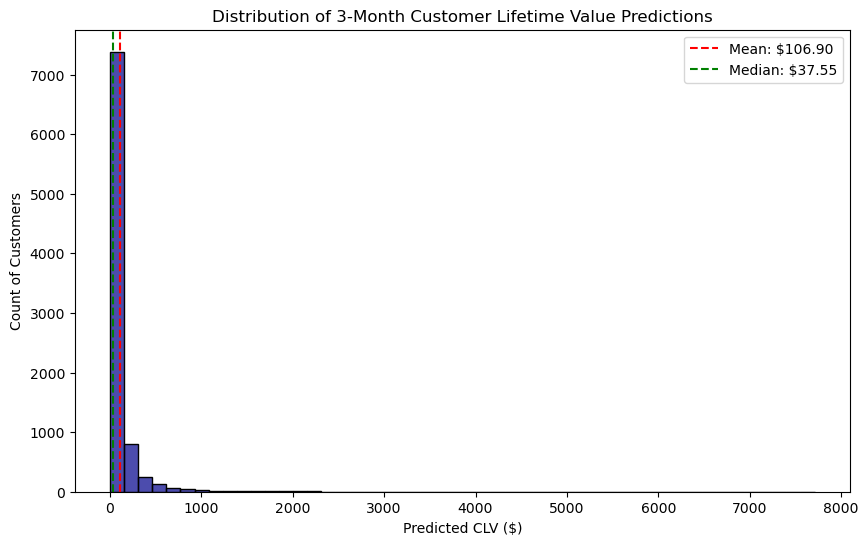

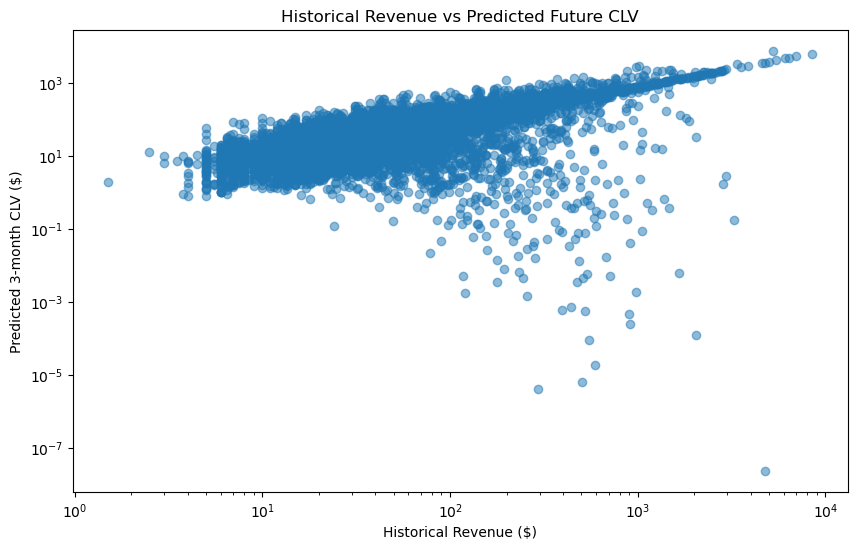

In [32]:
# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(clv, bins=50, color='darkblue', alpha=0.7)
plt.axvline(clv.mean(), color='red', linestyle='--', 
            label=f'Mean: ${clv.mean():.2f}')
plt.axvline(clv.median(), color='green', linestyle='--', 
            label=f'Median: ${clv.median():.2f}')
#plt.xscale('log')
plt.title('Distribution of 3-Month Customer Lifetime Value Predictions')
plt.xlabel('Predicted CLV ($)')
plt.ylabel('Count of Customers')
plt.legend()
plt.show()

# Forward-looking vs historical comparison plot
plt.figure(figsize=(10, 6))
plt.scatter(past_revenue, clv, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Historical Revenue ($)')
plt.ylabel('Predicted 3-month CLV ($)')
plt.title('Historical Revenue vs Predicted Future CLV')
plt.show()

In [33]:
# Check our time units
print("Average monthly revenue (historical):")
print(f"${past_revenue.sum() / summary_df['T'].max():.2f} per month")

# Look at monetary value distribution
print("\nMonetary value summary:")
print(summary_df['monetary_value'].describe())

# Check if time parameter is in the right units
# If time=3 means 3 weeks instead of 3 months, we should adjust:
clv_adjusted = ggf.customer_lifetime_value(
    bgf,
    summary_df['frequency'],
    summary_df['recency'],
    summary_df['T'],
    summary_df['monetary_value'],
    time=12,  # 12 weeks = ~3 months
    discount_rate=0.01
)

print("\nAdjusted CLV Summary:")
print(f"Total predicted future value (3 months): ${clv_adjusted.sum():.2f}")

Average monthly revenue (historical):
$11065.95 per month

Monetary value summary:
count    23705.000000
mean         9.578783
std         17.700023
min          0.000000
25%          0.000000
50%          0.000000
75%         17.200000
max        681.250000
Name: monetary_value, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



Adjusted CLV Summary:
Total predicted future value (3 months): $3082647.92


In [34]:
# Look at monetary values for only returning customers
print("Monetary value for returning customers:")
print(summary_df[summary_df['frequency'] > 0]['monetary_value'].describe())

# Check our customer segments
print("\nCustomer purchase frequency distribution:")
print(summary_df['frequency'].value_counts().sort_index())

Monetary value for returning customers:
count    8795.000000
mean       25.817516
std        20.619793
min         1.500000
25%        15.124167
50%        22.000000
75%        30.928571
max       681.250000
Name: monetary_value, dtype: float64

Customer purchase frequency distribution:
frequency
0.0     14910
1.0      3503
2.0      1680
3.0       915
4.0       597
        ...  
81.0        1
82.0        1
83.0        1
86.0        1
89.0        1
Name: count, Length: 73, dtype: int64


In [35]:
# CLV for different frequency segments
def calculate_segment_clv(min_freq, max_freq):
    segment = summary_df[(summary_df['frequency'] >= min_freq) & 
                        (summary_df['frequency'] <= max_freq)]
    if len(segment) == 0:
        return 0
    
    segment_clv = ggf.customer_lifetime_value(
        bgf,
        segment['frequency'],
        segment['recency'],
        segment['T'],
        segment['monetary_value'],
        time=12,  # 3 months in weeks
        discount_rate=0.01
    )
    return segment_clv.sum()

# Calculate for different segments
segments = {
    'New (1-2 visits)': (1, 2),
    'Occasional (3-12 visits)': (3, 12),
    'Regular (13-52 visits)': (13, 52),
    'Frequent (>52 visits)': (52, 100)
}

for name, (min_f, max_f) in segments.items():
    total_clv = calculate_segment_clv(min_f, max_f)
    n_customers = len(summary_df[(summary_df['frequency'] >= min_f) & 
                                (summary_df['frequency'] <= max_f)])
    print(f"\n{name}:")
    print(f"Number of customers: {n_customers}")
    print(f"Total 3-month CLV: ${total_clv:,.2f}")
    print(f"Average CLV per customer: ${total_clv/n_customers if n_customers else 0:,.2f}")


New (1-2 visits):
Number of customers: 5183
Total 3-month CLV: $592,813.63
Average CLV per customer: $114.38

Occasional (3-12 visits):
Number of customers: 3014
Total 3-month CLV: $1,236,087.31
Average CLV per customer: $410.12

Regular (13-52 visits):
Number of customers: 559
Total 3-month CLV: $982,137.51
Average CLV per customer: $1,756.95

Frequent (>52 visits):
Number of customers: 39
Total 3-month CLV: $271,609.47
Average CLV per customer: $6,964.35
